FAKE NEWS DETECTION USING BIDIRECTIONAL LSTM

In [ ]:
#install libraries
!pip install --upgrade tensorflow nltk wordcloud plotly scikit-learn

In [ ]:
#imports
import pandas as pd
import tensorflow as tf
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score,
    precision_score, recall_score, average_precision_score
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#load dataset
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [ ]:
#shape
print("True news shape:", df_true.shape)
print("Fake news shape:", df_fake.shape)

True news shape: (21417, 4)
Fake news shape: (23481, 4)


In [ ]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#add labels
df_true['labels'] = 1 #real
df_fake['labels'] = 0 #fake

In [ ]:
#combine datasets and reset index
df = pd.concat([df_true, df_fake], axis=0)
df.reset_index(drop=True, inplace=True)

In [ ]:
#drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
#drop all unused columns
df.drop(columns=['date', 'subject'], inplace=True)

In [ ]:
print("combibed shape:", df.shape)
df.head()

combibed shape: (44689, 3)


,title,text,labels
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
df['original'] = df['title'] + '' + df['text']
df.drop(columns=['title', 'text'], inplace=True)

In [ ]:
df['original'].iloc[0]

'As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['from', 'subject', 're', 'use'])

In [ ]:
#Text Preprocessing
def preprocess_text(text):
  if not isinstance(text, str):
    return  ""
  #lowercase
  text = text.lower()

  #remove HTML tags and urls
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'http\S+', '', text)

  #remove Reuters source tags
  text = re.sub(r'^.*?\(reuters\)\s*-\s*', '', text)
  text = re.sub(r'^[a-z\s/]+\s-\s', '', text) #generic city

  #remove special characters and digits
  text = re.sub(r'[^a-z\s]', '', text)

  #remove punctuation
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

  # Collapse extra whitespace / newlines
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()

  # Remove stop-words
  text = " ".join([w for w in text.split() if w not in stop_words])

  return text

In [ ]:
#apply preprocessing
df['clean'] = df['original'].apply(preprocess_text)

In [ ]:
#row inspection
print("original:\n", df['original'].iloc[0][:300])
print("\nCleaned:\n", df['clean'].iloc[0][:300])

original:
 As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged bu

Cleaned:
 head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republicans us representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers 


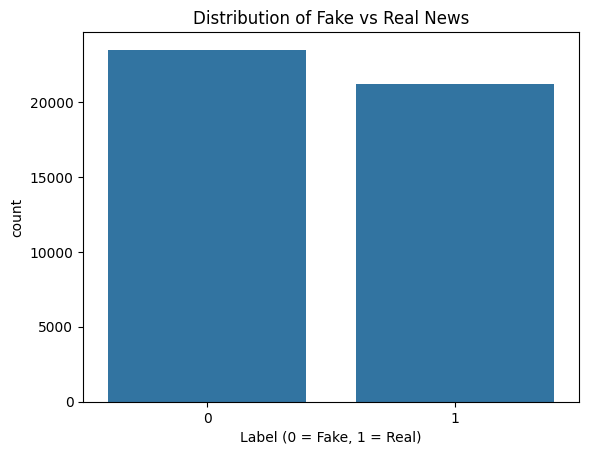

In [ ]:
#EDA Class balance
sns.countplot(x=df['labels'])
plt.title('Distribution of Fake vs Real News')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.show()

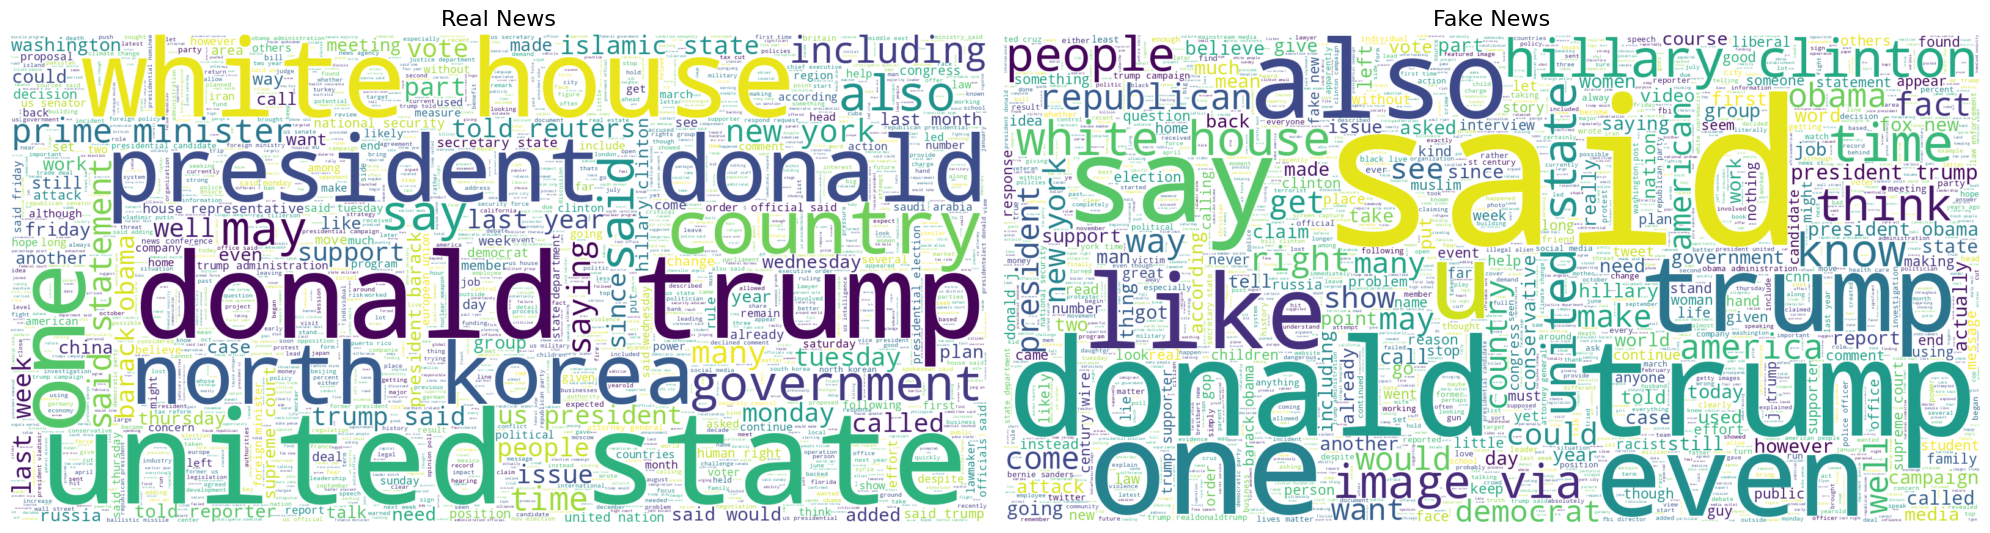

In [ ]:
#wordclouds
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for ax, label, title in zip(axes, [1, 0], ['Real News', 'Fake News']):
  text_data = ' '.join(df[df['labels'] == label]['clean'])
  wc = WordCloud(max_words=2000, width=1600, height=800,
                 stopwords=stop_words, background_color='white').generate(text_data)
  ax.imshow(wc, interpolation='bilinear')
  ax.set_title(title, fontsize=16)
  ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(
    df['clean'], df['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

In [ ]:
print(f"Train size: {len(x_train)}, Test size: {len(x_test)}")

Train size: 35751, Test size: 8938


In [ ]:
#fit temporary tokenizer to find vocab size from train data only
_temp_tok = Tokenizer()
_temp_tok.fit_on_texts(x_train)
total_words = len(_temp_tok.word_index) + 1 #for padding index 0
print(f"Vocabulary size(train only): {total_words:,}")

Vocabulary size(train only): 196,256


In [ ]:
#sequence length analysis
_train_seqs = _temp_tok.texts_to_sequences(x_train)
seq_lengths = [len(s) for s in _train_seqs]
smart_maxlen = int(np.percentile(seq_lengths, 95))
print(f"Max sequence length: {max(seq_lengths)}")
print(f"Smart maxlen (95th pct): {smart_maxlen}")

Max sequence length: 4846
Smart maxlen (95th pct): 522


Tokenizing and padding

In [ ]:
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train) # fit only on train


In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
padded_train = pad_sequences(
    train_sequences,
    maxlen=smart_maxlen,
    padding='post',
    truncating='post'
)
padded_test = pad_sequences(
    test_sequences,
    maxlen=smart_maxlen,
    padding='post',
    truncating='post'
)

In [ ]:
print(f"Padded train shape: {padded_train.shape}")
print(f"Padded test shape: {padded_test.shape}")

Padded train shape: (35751, 522)
Padded test shape: (8938, 522)


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
#word count histogram
fig = px.histogram(
    x=[len(s) for s in train_sequences],
    nbins=100,
    title='Distribution of sequence lengths (train set)',
    labels={'x': 'Sequence length', 'y': 'count'}
)
fig.show()

Model architecture

In [ ]:
model = Sequential([
    Embedding(total_words, output_dim=128, input_length=smart_maxlen),
    tf.keras.layers.SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#add early stopping to prevent overfitting
#ReduceLR0nPlateau gives optimizer chance to fine tune when validation loss stops improving
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

In [ ]:
history = model.fit(
    padded_train, y_train,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 65s 109ms/step - accuracy: 0.8908 - loss: 0.2150 - val_accuracy: 0.9880 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 2/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.9855 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 3/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
503/503 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9877 - val_loss: 0.0522 - learning_rate: 0.0010
Epoch 4/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9997 - loss: 8.0828e-04 - val_accuracy: 0.9877 - val_loss: 0.0603 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Train curves

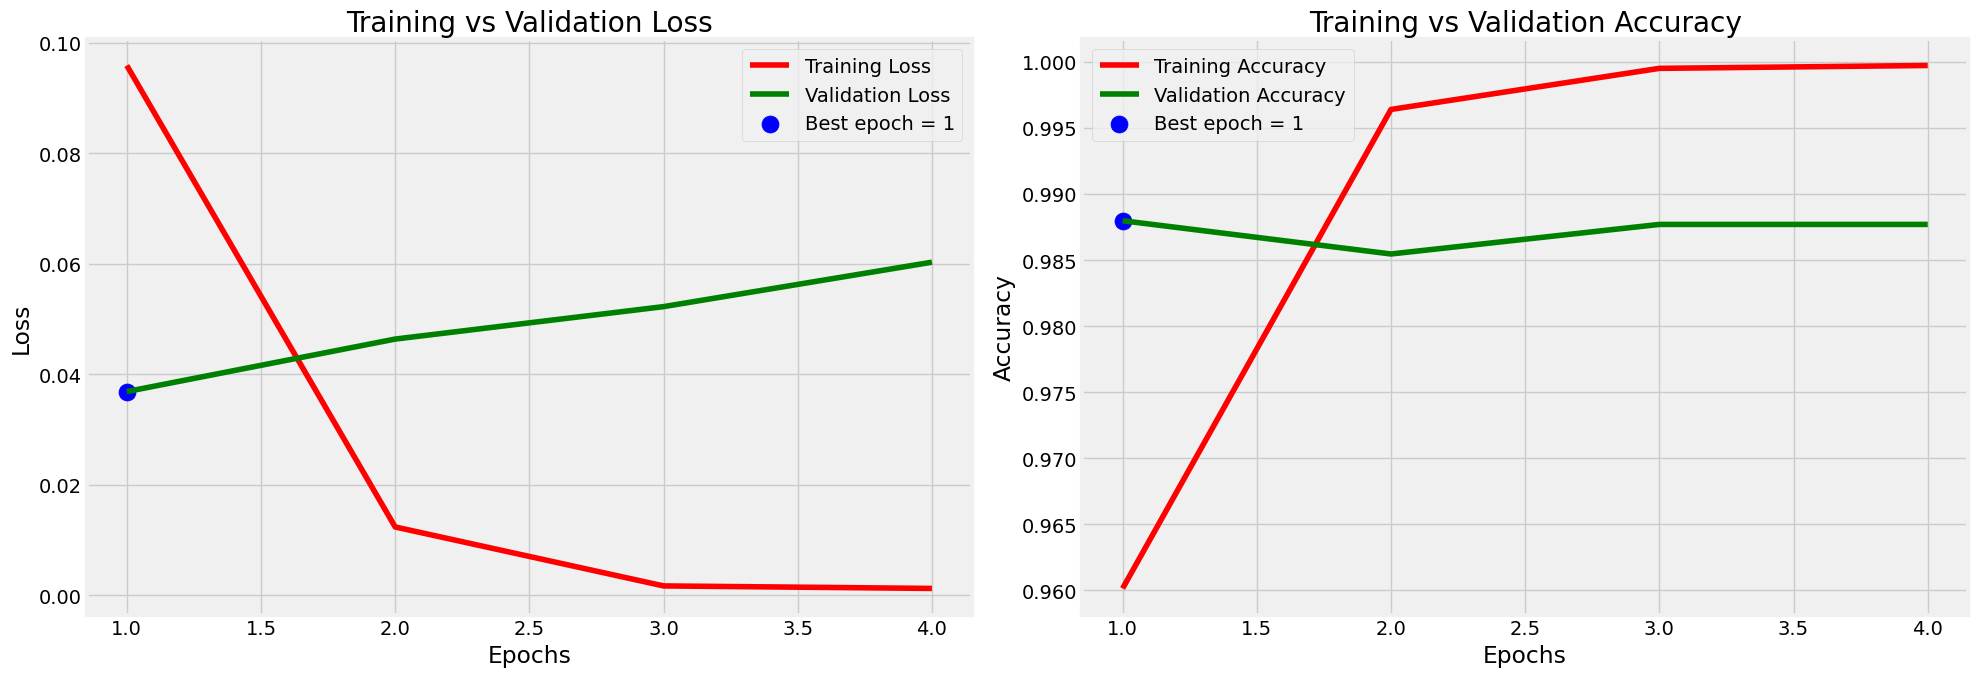

In [ ]:
#Training curves
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
Epochs = list(range(1, len(tr_acc) + 1))

plt.figure(figsize=(20, 7))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss,  'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_loss[index_loss], s=150, c='blue',
            label=f'Best epoch = {index_loss + 1}')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc,  'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_acc[index_acc], s=150, c='blue',
            label=f'Best epoch = {index_acc + 1}')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Evaluation
pred_probs = model.predict(padded_test).flatten()
prediction = (pred_probs > 0.5).astype(int)

print("Model Accuracy:", accuracy_score(y_test, prediction))
print("\nClassification Report:\n", classification_report(y_test, prediction, target_names=['Fake', 'Real']))

280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
Model Accuracy: 0.9895949876929961

Classification Report:
               precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



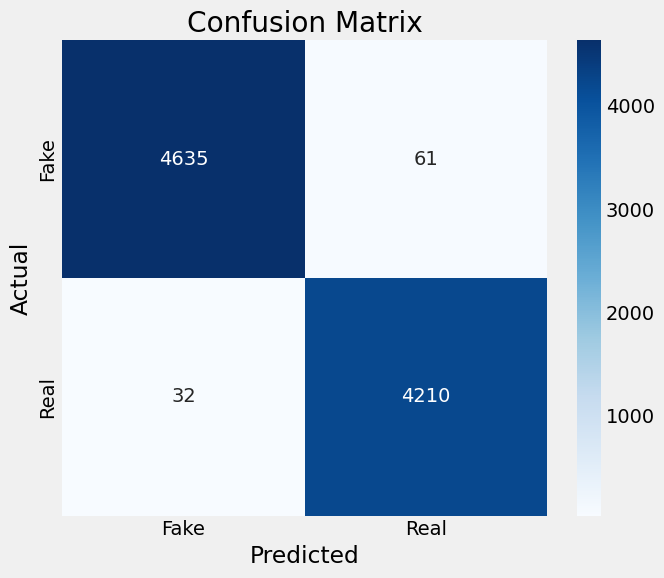

In [ ]:
#cofusion matrix
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

AUC-ROC - ROC curve plots true positive vs false positive rate across every possible threshold. <br> AUC (Area Under Curve) summarises the whole curve in one number

In [ ]:
#AUC-ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

print(f"\n{'='*50}")
print(f" AUC-ROC Score: {roc_auc:.4f}")
print(f"{'='*50}")


 AUC-ROC Score: 0.9994


In [ ]:
#find the optimal threshold
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_thresh_roc = roc_thresholds[optimal_idx]
print(f" Optimal Threshold (Youden J): {optimal_thresh_roc:.4f}")
print(f" TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f" FPR at optimal: {fpr[optimal_idx]:.4f}")

fig_roc = go.Figure()
#diagonal random guess baseline
fig_roc.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='#aaaaaa', dash='dash', width=1.5),
    name='Random Classifier (AUC = 0.50)',
    hoverinfo='skip'
))

# ROC curve with colour gradient via a filled area
fig_roc.add_trace(go.Scatter(
    x=fpr, y=tpr,
    mode='lines',
    line=dict(color='#6c63ff', width=3),
    fill='tozeroy',
    fillcolor='rgba(108,99,255,0.12)',
    name=f'LSTM Classifier (AUC = {roc_auc:.4f})',
))

# Mark the optimal operating point
fig_roc.add_trace(go.Scatter(
    x=[fpr[optimal_idx]], y=[tpr[optimal_idx]],
    mode='markers+text',
    marker=dict(color='#e63946', size=12, symbol='star'),
    text=[f"  Optimal (t={optimal_thresh_roc:.2f})"],
    textposition='middle right',
    name=f'Optimal threshold = {optimal_thresh_roc:.2f}',
))

fig_roc.update_layout(
    title=dict(text='ROC Curve — Receiver Operating Characteristic',
               font=dict(size=18)),
    xaxis=dict(title='False Positive Rate', range=[0, 1]),
    yaxis=dict(title='True Positive Rate',  range=[0, 1.02]),
    legend=dict(x=0.5, y=0.15, bgcolor='rgba(255,255,255,0.8)',
                bordercolor='#ddd', borderwidth=1),
    width=750, height=500,
    paper_bgcolor='white', plot_bgcolor='#f9f9fc',
)
fig_roc.show()

 Optimal Threshold (Youden J): 0.6262
 TPR at optimal: 0.9903
 FPR at optimal: 0.0100


Precision Recall curve

In [ ]:
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, pred_probs)
avg_precision = average_precision_score(y_test, pred_probs)

print(f"\n{'='*50}")
print(f"  Average Precision (AP): {avg_precision:.4f}")
print(f"{'='*50}")


  Average Precision (AP): 0.9993


In [ ]:
# Optimal threshold = max F1 on the curve
f1_scores_curve = (2 * precision_vals[:-1] * recall_vals[:-1]
                   / (precision_vals[:-1] + recall_vals[:-1] + 1e-9))
optimal_idx_pr      = np.argmax(f1_scores_curve)
optimal_thresh_pr   = pr_thresholds[optimal_idx_pr]
print(f"  Optimal Threshold (max F1): {optimal_thresh_pr:.4f}")
print(f"  Precision at optimal: {precision_vals[optimal_idx_pr]:.4f}")
print(f"  Recall    at optimal: {recall_vals[optimal_idx_pr]:.4f}")
print(f"  F1        at optimal: {f1_scores_curve[optimal_idx_pr]:.4f}")

# Baseline = fraction of positives (random classifier)
baseline = y_test.sum() / len(y_test)

fig_pr = go.Figure()

fig_pr.add_trace(go.Scatter(
    x=[0, 1], y=[baseline, baseline],
    mode='lines',
    line=dict(color='#aaaaaa', dash='dash', width=1.5),
    name=f'Random Classifier (AP = {baseline:.2f})',
    hoverinfo='skip'
))

fig_pr.add_trace(go.Scatter(
    x=recall_vals, y=precision_vals,
    mode='lines',
    line=dict(color='#52b788', width=3),
    fill='tozeroy',
    fillcolor='rgba(82,183,136,0.12)',
    name=f'LSTM Classifier (AP = {avg_precision:.4f})',
))

fig_pr.add_trace(go.Scatter(
    x=[recall_vals[optimal_idx_pr]],
    y=[precision_vals[optimal_idx_pr]],
    mode='markers+text',
    marker=dict(color='#e63946', size=12, symbol='star'),
    text=[f"  Optimal (t={optimal_thresh_pr:.2f}, F1={f1_scores_curve[optimal_idx_pr]:.3f})"],
    textposition='middle right',
    name=f'Optimal threshold = {optimal_thresh_pr:.2f}',
))

fig_pr.update_layout(
    title=dict(text='Precision-Recall Curve',
               font=dict(size=18)),
    xaxis=dict(title='Recall',    range=[0, 1]),
    yaxis=dict(title='Precision', range=[0, 1.02]),
    legend=dict(x=0.05, y=0.15, bgcolor='rgba(255,255,255,0.8)',
                bordercolor='#ddd', borderwidth=1),
    width=750, height=500,
    paper_bgcolor='white', plot_bgcolor='#f9f9fc',
)
fig_pr.show()

  Optimal Threshold (max F1): 0.6262
  Precision at optimal: 0.9889
  Recall    at optimal: 0.9903
  F1        at optimal: 0.9896


In [ ]:
thresholds       = np.arange(0.01, 1.00, 0.01)
accs, precs, recs, f1s = [], [], [], []

for t in thresholds:
    preds = (pred_probs > t).astype(int)
    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds, zero_division=0))
    recs.append(recall_score(y_test, preds,    zero_division=0))
    f1s.append(f1_score(y_test, preds,         zero_division=0))

# Best F1 threshold
best_f1_thresh = thresholds[np.argmax(f1s)]
print(f"\nThreshold with highest F1: {best_f1_thresh:.2f}  "
      f"(F1 = {max(f1s):.4f})")

fig_thresh = go.Figure()

for vals, name, color in [
    (accs,  'Accuracy',  '#4a90d9'),
    (precs, 'Precision', '#f4a261'),
    (recs,  'Recall',    '#e63946'),
    (f1s,   'F1-Score',  '#52b788'),
]:
    fig_thresh.add_trace(go.Scatter(
        x=thresholds, y=vals,
        mode='lines', name=name,
        line=dict(color=color, width=2.5),
    ))

# Vertical line at default 0.5
fig_thresh.add_vline(
    x=0.5, line_dash='dash', line_color='#888',
    annotation_text='Default (0.5)',
    annotation_position='top right',
)
# Vertical line at best F1 threshold
fig_thresh.add_vline(
    x=best_f1_thresh, line_dash='dot', line_color='#52b788',
    annotation_text=f'Best F1 ({best_f1_thresh:.2f})',
    annotation_position='top left',
)

fig_thresh.update_layout(
    title=dict(text='Threshold Sensitivity — Metrics vs Decision Threshold',
               font=dict(size=18)),
    xaxis=dict(title='Decision Threshold', range=[0, 1]),
    yaxis=dict(title='Score',              range=[0, 1.02]),
    legend=dict(orientation='h', y=-0.2),
    width=900, height=480,
    paper_bgcolor='white', plot_bgcolor='#f9f9fc',
    hovermode='x unified',
)
fig_thresh.show()


Threshold with highest F1: 0.62  (F1 = 0.9896)


In [ ]:
# Compare Fake vs Real class metrics side-by-side as a bar chart.

report_dict = classification_report(
    y_test, prediction,
    target_names=['Fake', 'Real'],
    output_dict=True
)

classes   = ['Fake', 'Real']
metrics   = ['precision', 'recall', 'f1-score']
colors    = ['#e63946', '#52b788', '#4a90d9']

fig_cls = go.Figure()
for metric, color in zip(metrics, colors):
    fig_cls.add_trace(go.Bar(
        name=metric.capitalize(),
        x=classes,
        y=[report_dict['Fake'][metric], report_dict['Real'][metric]],
        marker_color=color,
        text=[f"{report_dict['Fake'][metric]:.3f}",
              f"{report_dict['Real'][metric]:.3f}"],
        textposition='outside',
    ))

fig_cls.update_layout(
    title=dict(text='Per-Class Metrics — Precision, Recall & F1',
               font=dict(size=18)),
    barmode='group',
    yaxis=dict(title='Score', range=[0, 1.1]),
    xaxis=dict(title='Class'),
    legend=dict(orientation='h', y=-0.15),
    width=600, height=450,
    paper_bgcolor='white', plot_bgcolor='#f9f9fc',
)
fig_cls.show()

In [ ]:
best_thresh_preds = (pred_probs > best_f1_thresh).astype(int)

scorecard = {
    # Standard threshold (0.5) metrics
    'accuracy_at_0.5':           round(float(accuracy_score(y_test, prediction)),          4),
    'precision_fake_at_0.5':     round(float(report_dict['Fake']['precision']),             4),
    'recall_fake_at_0.5':        round(float(report_dict['Fake']['recall']),                4),
    'f1_fake_at_0.5':            round(float(report_dict['Fake']['f1-score']),              4),
    'precision_real_at_0.5':     round(float(report_dict['Real']['precision']),             4),
    'recall_real_at_0.5':        round(float(report_dict['Real']['recall']),                4),
    'f1_real_at_0.5':            round(float(report_dict['Real']['f1-score']),              4),
    'macro_f1_at_0.5':           round(float(report_dict['macro avg']['f1-score']),         4),
    # Threshold-independent metrics
    'roc_auc':                   round(float(roc_auc),                                      4),
    'average_precision':         round(float(avg_precision),                                4),
    # Optimal-threshold metrics
    'optimal_threshold_f1':      round(float(best_f1_thresh),                              4),
    'accuracy_at_optimal':       round(float(accuracy_score(y_test, best_thresh_preds)),    4),
    'f1_fake_at_optimal':        round(float(f1_score(y_test, best_thresh_preds,
                                                       pos_label=0, zero_division=0)),      4),
    'f1_real_at_optimal':        round(float(f1_score(y_test, best_thresh_preds,
                                                       pos_label=1, zero_division=0)),      4),
    # Confusion matrix at 0.5
    'tp': int(cm[1, 1]), 'tn': int(cm[0, 0]),
    'fp': int(cm[0, 1]), 'fn': int(cm[1, 0]),
    # Curve data for Streamlit (sampled for file size)
    'roc_fpr':          fpr[::5].tolist(),
    'roc_tpr':          tpr[::5].tolist(),
    'pr_precision':     precision_vals[::5].tolist(),
    'pr_recall':        recall_vals[::5].tolist(),
    'thresh_x':         thresholds[::2].tolist(),
    'thresh_acc':       [accs[i]  for i in range(0, len(thresholds), 2)],
    'thresh_prec':      [precs[i] for i in range(0, len(thresholds), 2)],
    'thresh_rec':       [recs[i]  for i in range(0, len(thresholds), 2)],
    'thresh_f1':        [f1s[i]   for i in range(0, len(thresholds), 2)],
}

print("\n" + "="*60)
print("  MODEL EVALUATION SCORECARD")
print("="*60)
print(f"  AUC-ROC              : {scorecard['roc_auc']}")
print(f"  Average Precision    : {scorecard['average_precision']}")
print(f"  Accuracy  (t=0.50)   : {scorecard['accuracy_at_0.5']}")
print(f"  Macro F1  (t=0.50)   : {scorecard['macro_f1_at_0.5']}")
print(f"  Fake F1   (t=0.50)   : {scorecard['f1_fake_at_0.5']}")
print(f"  Real F1   (t=0.50)   : {scorecard['f1_real_at_0.5']}")
print(f"  Optimal threshold    : {scorecard['optimal_threshold_f1']}")
print(f"  Accuracy  (optimal)  : {scorecard['accuracy_at_optimal']}")
print("="*60)


  MODEL EVALUATION SCORECARD
  AUC-ROC              : 0.9994
  Average Precision    : 0.9993
  Accuracy  (t=0.50)   : 0.9896
  Macro F1  (t=0.50)   : 0.9896
  Fake F1   (t=0.50)   : 0.9901
  Real F1   (t=0.50)   : 0.9891
  Optimal threshold    : 0.62
  Accuracy  (optimal)  : 0.9902


In [ ]:
#save the model and tokenizer
model.save('fake_true_news_lstm_model.keras')
print("Model saved as 'fake_true_news_lstm_model.keras'")

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved as 'tokenizer.pickle'")

with open('model_config.json', 'w') as f:
    json.dump({'smart_maxlen': int(smart_maxlen), 'total_words': int(total_words)}, f, indent=2)
print("model_config.json saved.")

with open('eval_metrics.json', 'w') as f:
    json.dump(scorecard, f, indent=2)
print("eval_metrics.json saved ")

Model saved as 'fake_true_news_lstm_model.keras'
Tokenizer saved as 'tokenizer.pickle'
model_config.json saved.
eval_metrics.json saved 


In [ ]:
#inference helper
def predict_news(text: str) -> dict:
  """Return {'label': 'Real'/'Fake', 'confidence': float}."""
  cleaned = preprocess_text(text)
  seq = tokenizer.texts_to_sequences([cleaned])
  padded = pad_sequences(seq, maxlen=smart_maxlen,
                         padding='post', truncating='post')
  prob = model.predict(padded, verbose=0)[0][0]
  label = 'REAL' if prob > 0.5 else 'FAKE'
  confidence = prob if prob > 0.5 else 1 - prob
  return {'label': label, 'confidence': round(float(confidence), 4)}

In [ ]:
#demo
sample = "Scientists discover new planent could support life."
print(predict_news(sample))

{'label': 'FAKE', 'confidence': 0.9979}
